# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [71]:
pip install citipy

Note: you may need to restart the kernel to use updated packages.


In [72]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [73]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

saved_lats = []
saved_longs = []

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        saved_lats.append(lat_lng[0])
        saved_longs.append(lat_lng[1])

# Print the city count to confirm sufficient count
len(cities)

601

In [117]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

saved_lats = []
saved_longs = []
cloudiness = []
# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    #also add estimated latitude and longitude
    if city not in cities:
        cities.append(city)
        saved_lats.append(lat_lng[0])
        saved_longs.append(lat_lng[1])
        
# print(citipy.nearest_city(0, 0).keys())

# Print the city count to confirm sufficient count
#print("{} cities have been identified to poll for weather".format(len(cities)))

city_list = pd.DataFrame({"City":cities, "Latitude":saved_lats, "Longitude":saved_longs})
# city_list = pd.DataFrame({"City":cities})

#save to a csv (for reference - can compare estimated coordinates to actual coordinates if there is time, which cannot be done
#easily with citipy because the references only go one way -> approx. coordinates to city name, not city name to actual 
#coordinates)
city_list.to_csv("./Cities.csv")
city_list.head()

,City,Latitude,Longitude
0,beckley,37.825550,-81.361511
1,auki,-3.616685,163.481137
2,bredasdorp,-77.262278,19.643294
3,rikitea,-28.413792,-131.828899
4,lavrentiya,79.576940,-168.990282


In [114]:
# Save config information.
#url = "https://openweathermap.org/api?"
#units = "metric"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

#url for advanced mapping using OpenWeatherMap's new OneCall API to get historical weather info by coordinates instead of 
#city names - not implemented for project initially due to setup being different
# base_url = "https://api.openweathermap.org/data/2.5/onecall?lat={lat}&lon={lon}&exclude={part}&appid={YOUR API KEY}"
# params = {"exclude":"minutely,hourly,current", "appid":weather_api_key, "lat":city_list["Latitude"][0], 
#           "lon":city_list["Longitude"][0]}

#setup columns for temperature, humidity, cloudiness, and wind speed
city_list["Max Temperature (F)"] = ""
city_list["Humidity (%)"] = ""
city_list["Cloudiness"] = ""
city_list["Wind Speed (mph)"] = ""

#setup columns for actual latitude and longitude
city_list["Latitude"] = ""
city_list["Longitude"] = ""

#setup column for country code
city_list["Country"] = ""

#setup column for city datetime
city_list["Datetime (Local)"] = ""
#note that current timezone is PST (-7:00 from GMT)
PST_offset = 7*60*60


base_url_current = "https://openweathermap.org/api/data/2.5/weather"
params = {"q":city_list["City"][0], "units":"metric", "appid":weather_api_key}

test_response = requests.get(base_url_current, params)
json_response = test_response.json()
# json.dumps(json_response, indent=4)


#establish pattern for getting data into columns from json object
city_list["Latitude"][0] = json_response["coord"]["lat"]
city_list["Longitude"][0] = json_response["coord"]["lon"]
city_list["Max Temperature (F)"][0] = json_response["main"]["temp_max"]
city_list["Humidity (%)"][0] = json_response["main"]["humidity"]
city_list["Cloudiness"][0] = json_response["clouds"]["all"]
city_list["Wind Speed (mph)"][0] = json_response["wind"]["speed"]
city_list["Country"][0] = json_response["sys"]["country"]
#create datetime.datetime object to give local date and time at the city of interest (need to add an offset from our 
#computer clock set to PST and then add in the timezone shift given by the API to change from GMT)
first_city_time = datetime.datetime.fromtimestamp(json_response["dt"]+json_response["timezone"]+PST_offset)
city_list["Datetime (Local)"][0] = first_city_time.strftime("%m/%d/%Y, %H:%M:%S")

#create helper function to give the Datetime (UTC) column string
def getTimeString(resp_json, comp_time):
    curr_city_datetime = datetime.datetime.fromtimestamp(resp_json["dt"]+resp_json["timezone"]+comp_time)
    return curr_city_datetime.strftime("%m/%d/%Y, %H:%M:%S")

#create function to add all info to dataframe using the above pattern 
def addColumns(pd_df, resp_json, i, comp_time):
    pd_df["Latitude"][i] = resp_json["coord"]["lat"]
    pd_df["Longitude"][i] = resp_json["coord"]["lon"]
    pd_df["Max Temperature (F)"][i] = resp_json["main"]["temp_max"]
    pd_df["Humidity (%)"][i] = resp_json["main"]["humidity"]
    pd_df["Cloudiness"][i] = resp_json["clouds"]["all"]
    pd_df["Wind Speed (mph)"][i] = resp_json["wind"]["speed"]
    pd_df["Country"][i] = resp_json["sys"]["country"]
    #create datetime.datetime object to give local date and time at the city of interest (need to add an offset from our 
    #computer clock set to PST and then add in the timezone shift given by the API to change from GMT)
    #change it to a string to keep the timestamp the same in case it is examined later
    pd_df["Datetime (Local)"][i] = getTimeString(resp_json, comp_time)

JSONDecodeError: [Errno Expecting value] <!DOCTYPE html>
<html lang='en'>
    <head>
        <!-- smart banner apple -->
        <meta name="apple-itunes-app" content="app-id=1535923697">
        <script data-ad-client="ca-pub-6837309406068967" async src="https://pagead2.googlesyndication.com/pagead/js/adsbygoogle.js"></script>
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8">    
    <meta  http-equiv=Expires content="Tue, Sep 20 2018 15:27:22 GMT">
    <meta http-equiv="Last-Modified" content="Tue, Sep 20 2018 15:27:22 GMT">
    <!--<meta http-equiv="X-UA-Compatible" content="IE=edge">-->
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <meta name="keywords" content="weather, world, Openstreetmap, forecast, Openweather, current" >
    <meta name="description" content="" >
    <meta name="author" content="OpenWeatherMap.org">
    <meta name="domain" content="OpenWeatherMap.org" >        
    <meta name="p:domain_verify" content="34fe229eab8562dca90f4a5962ff80a9"/>
    <meta property="title" content="Page not found (404)" />                <link rel="shortcut icon" href="/themes/openweathermap/assets/vendor/owm/img/icons/favicon.ico" />
<link rel="icon" href="/themes/openweathermap/assets/vendor/owm/img/icons/logo_16x16.png" sizes="16x16" type="image/png">
<link rel="icon" href="/themes/openweathermap/assets/vendor/owm/img/icons/logo_32x32.png" sizes="32x32" type="image/png">
<link rel="icon" href="/themes/openweathermap/assets/vendor/owm/img/icons/logo_60x60.png" sizes="60x60" type="image/png">   
        <title>Page not found (404) - OpenWeatherMap</title>
        <!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=UA-31601618-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-31601618-1');
</script>        
        <script src="//code.jquery.com/jquery-1.9.1.min.js" integrity="sha256-wS9gmOZBqsqWxgIVgA8Y9WcQOa7PgSIX+rPA0VL2rbQ=" crossorigin="anonymous"></script>
<script src="https://cdn.polyfill.io/v2/polyfill.min.js?features=Array.from,Array.assign,fetch&flags=always,gated"></script>
<script src='/themes/openweathermap/assets/js/bundle_owm_preload.c31872127471c475ade1.js'></script>            
        <link href='/themes/openweathermap/assets/css/bundle_owm_styles.c31872127471c475ade1.css' rel="stylesheet"> 
<link href='/themes/openweathermap/assets/css/stick_footer_panel.c31872127471c475ade1.css' rel="stylesheet">
<!-- Resources -->
<!--link href='/themes/openweathermap/assets/vendor/mosaic/fonts/font-awesome/css/font-awesome.min.css' rel="stylesheet"-->            
<link href="https://maxcdn.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css" rel="stylesheet" integrity="sha384-wvfXpqpZZVQGK6TAh5PVlGOfQNHSoD2xbE+QkPxCAFlNEevoEH3Sl0sibVcOQVnN" crossorigin="anonymous">
<link href='https://fonts.googleapis.com/css?family=Oswald:400,700,300' rel='stylesheet' rel="stylesheet">
<link href='https://fonts.googleapis.com/css?family=Roboto:400,700,500,400italic,500italic' rel="stylesheet">        <link href='/themes/openweathermap/assets/css/new_owm_styles.635b0c2ecd513644.css' rel="stylesheet"> 

<!-- Resources -->
<!--link href='/themes/openweathermap/assets/vendor/mosaic/fonts/font-awesome/css/font-awesome.min.css' rel="stylesheet"-->            
<link href="https://maxcdn.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css" rel="stylesheet" integrity="sha384-wvfXpqpZZVQGK6TAh5PVlGOfQNHSoD2xbE+QkPxCAFlNEevoEH3Sl0sibVcOQVnN" crossorigin="anonymous">
<link href='https://fonts.googleapis.com/css?family=Oswald:400,700,300' rel='stylesheet' rel="stylesheet">
<link href='https://fonts.googleapis.com/css?family=Roboto:400,700,500,400italic,500italic' rel="stylesheet">    
        
    </head>
    <body class="body-orange" onClick="closePopUps()">
                    <style>
    .banner_stripe {
        width: 100%; 
        height: 80px; 
        background-color: #1c1c1e;
        display: none;
        flex-direction: row;
        justify-content: space-between;
        align-items: center;
        padding: 8px;
        font-family: Roboto,sans-serif;
        position: relative;
        z-index: 5;
    }
    .banner_container {
        display: flex; 
        flex-direction: row; 
        align-items: center; 
        margin-left: 18px;
        }
    .banner_icon {
        width: 64px;
        height: 64px;
        border-radius: 15px;
        background-size: 64px 64px;
        margin: 8px;
    }
    .google_button {
        /* background-color: #3e83f8; */
        background-color: #2196f3;
        height: 36px;
        border: 0;
        display: flex;
        align-items: center;
        justify-content: center;
        border-radius: 5px;
        box-shadow: 0 2px 5px rgba(0,0,0,.26);
        box-sizing: border-box;
        color: #fff !important;
        cursor: pointer;
        font-size: 14px;
        font-weight: 500;
        letter-spacing: .5px;
        line-height: 24px;
        margin: 6px;
        min-width: 40px;
        outline: 0;
        padding: 10px 14px;
        position: relative;
        text-align: center;
        text-decoration: none;
        text-transform: uppercase;
        transition: box-shadow .4s cubic-bezier(.25,.8,.25,1),background-color .4s cubic-bezier(.25,.8,.25,1);
        white-space: nowrap;
        -webkit-user-select: none;
        -moz-user-select: none;
        -ms-user-select: none;
        user-select: none;
    }
    .google_button:hover, .google_button:focus {
        text-decoration: none;
    }
    .smartbanner__exit {
        position: absolute;
        top: calc(50% - 6px);
        left: 12px;
        display: block;
        margin: 0;
        width: 12px;
        height: 12px;
        border: 0;
        text-align: center; 
        }
    .smartbanner__exit::before, .smartbanner__exit::after {
      position: absolute;
      width: 1px;
      height: 12px;
      content: ' ';
      background: #767676;
      }
    .smartbanner__exit::before {
      transform: rotate(45deg); }
    .smartbanner__exit::after {
      transform: rotate(-45deg); }
    .smartbanner-text {
        font-size: 12px; 
        margin: 0; 
        color: #96969c;
     }
</style>

<div id="banner_android" class="banner_stripe">
    <div class="banner_container">
        <a class="smartbanner__exit" onClick="bannerClose()"></a>
        <img src="/themes/openweathermap/assets/img/mobile_app/android-app-top-banner.png" class="banner_icon" />
        <div>
            <p class="smartbanner-text" style="color: #ffffff;">OpenWeather</p>
            <p class="smartbanner-text">OpenWeather Ltd.</p>
            <p class="smartbanner-text">GET - on Google Play</p>
        </div>
    </div>
    <a class="google_button" style="font-size: 16px;" href="https://play.google.com/store/apps/details?id=uk.co.openweather" onclick="ga('send', 'event', 'app', 'click', 'androidTopBanner');">VIEW</a>
</div>

<script>
    
    var bannerClosed = "owm_banner_android_closed"
    
    function getCookie(name) {
      const value = `; ${document.cookie}`;
      const parts = value.split(`; ${name}=`);
      if (parts.length === 2) return parts.pop().split(';').shift();
    }
    
    function setCookie (name, value) {
        var expires = new Date()
        expires.setTime(expires.getTime() + (5 * 1000 * 60 * 60 * 24))
        document.cookie = name + '=' + escape(value) + '; expires=' + expires.toGMTString() + '; path=/'
      }
      
    function bannerClose() {
        document.getElementById("banner_android").style.display = "none";
        setCookie(bannerClosed, true)
    }
    
    document.onload = function(bannerClosed) {
       if ((document.cookie.indexOf() === -1)  && /Android/i.test(window.navigator.userAgent)) {
           document.getElementById("banner_android").style.display = 'flex';
        } 
    }()
    
    
</script>   
                <nav id="nav-website" onClick="toggleMenu(event)">
  <ul id="first-level-nav">
    <li class="logo">
      <a href="/">
        <img src="/themes/openweathermap/assets/img/logo_white_cropped.png">
      </a>
    </li>
    <li id="hamburger">
      <img src="/themes/openweathermap/assets/img/owm_icons/icon_hamburger.svg"/>
    </li>
    <div id="desktop-menu">
    <form role="search" action="/find" method="get">
      <input type="text" name="q"  placeholder="Weather in your city">
      <input type="submit" style="display:none;">
    </form>
    <ul>
      <li>
        <a href="/guide" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'weather']);">Guide</a>
      </li>
      <li>
        <a href="/api" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'api']);">API</a>
      </li>
        <li>
        <a href="/weather-dashboard" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'dashboard']);">Dashboard</a>
      </li>
      <li>
        <a href="https://home.openweathermap.org/marketplace" target="_blank" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'dashboard']);">Marketplace</a>
      </li>
      <li>
        <a href="/price" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'price']);">Pricing</a>
      </li>
      <li>
        <a href="/weathermap" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'weather']);">Maps</a>
      </li>
      <li>
        <a href="/our-initiatives" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'weather']);">Our Initiatives</a>
      </li>
      <li>
        <a href="/examples" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'examples']);">Partners</a>
      </li>
      <li>
        <a href="https://openweather.co.uk/blog/category/weather" target="_blank" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'news']);">Blog</a>
      </li>
      <li>
        <a href="https://openweather.co.uk" class="marketplace" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'marketplace']);" target="_blank">For Business</a>
      </li>
              <li class="user-li"><a href="https://openweathermap.org/home/sign_in">Sign in</a></li>
              <li class="with-dropdown">
          <div id="support-dropdown">Support</div>
          <ul class="dropdown-menu" id="support-dropdown-menu">
            <li><a href="/faq">FAQ</a></li>
            <li><a href="/appid">How to start</a></li>
            <li><a href="https://home.openweathermap.org/questions" target="_blank">Ask a question</a></li>
          </ul>
        </li>
      </ul>
  </div>
  </ul>
  <ul id="mobile-menu">
    <li>
      <form role="search" action="/find" method="get">
        <input type="text" name="q"  placeholder="Weather in your city">
        <input type="submit" style="display:none;">
      </form>
    </li>
    <li>
      <a href="/guide" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'weather']);">Guide</a>
    </li>
    <li>
      <a href="/api" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'api']);">API</a>
    </li>
    <li>
        <a href="/weather-dashboard" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'dashboard']);">Dashboard</a>
      </li>
      <li>
        <a href="https://home.openweathermap.org/marketplace" target="_blank" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'dashboard']);">Marketplace</a>
      </li>
    <li>
      <a href="/price" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'price']);">Pricing</a>
    </li>
    <li>
      <a href="/weathermap" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'weather']);">Maps</a>
    </li>
    <li>
      <a href="/our-initiatives" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'weather']);">Our Initiatives</a>
    </li>
    <li>
      <a href="/examples" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'examples']);">Partners</a>
    </li>
    <li>
      <a href="https://openweather.co.uk/blog/category/weather" target="_blank" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'news']);">Blog</a>
    </li>
    <li>
        <a href="https://openweather.co.uk" class="marketplace" onclick="_gaq.push(['_trackEvent', 'Navbar', 'Main', 'marketplace']);" target="_blank">For Business</a>
      </li>
    <li>
      <a href="https://home.openweathermap.org/questions">Ask a question</a>
    </li>
          <li><a href="https://openweathermap.org/home/sign_in">Sign in</a></li>
      </ul>
</nav>
<div style="height: 48pt; width: 100%; visibility: hidden;"></div> 
        <div id="notes_block"></div>
        <main class="wrapper"> 
                                    <div class="container">
<div class="row">
<div class="col-sm-12">
        <h1>Page not found</h1>  
        <p>We're sorry, but the page you requested cannot be found.</p>
</div>
</div>
</div>     
                                    <div class="container">
                <div class="row">
                    <div class="col-sm-12">
                        <script async src="//pagead2.googlesyndication.com/pagead/js/adsbygoogle.js"></script>
<!-- 728x90 -->
<ins class="adsbygoogle"
     style="display:inline-block;width:728px;height:90px"
     data-ad-client="ca-pub-6837309406068967"
     data-ad-slot="6027350861"></ins>
<script>
     (adsbygoogle = window.adsbygoogle || []).push({});
</script>                    </div>
                </div>                
            </div>
                        
        </main>
        <div id="stick-footer-panel"></div>
                    <div id="footer-website" onClick="toggleFooterSection(event)">
   <div class="inner-footer-container"/>
      <div class="horizontal-section">
         <div class="footer-section">
            <p class="section-heading">Product Collections</p>
            <div class="section-content">
               <ul>
                  <li><a href="/api#current">Current and Forecast APIs</a></li>
                  <li><a href="/api#history">Historical Weather Data</a></li>
                  <li><a href="/api#maps">Weather Maps</a></li>
                  <li><a href="/weather-dashboard">Weather Dashboard</a></li>
                  <li><a href="/widgets-constructor">Widgets</a></li>
               </ul>
            </div>
         </div>
         <div class="footer-section">
            <p class="section-heading">Subscription</p>
            <div class="section-content">
               <ul>
                  <li><a href="/appid">How to start</a></li>
                  <li><a href="/price">Pricing</a></li>
                  <li><a href="https://home.openweathermap.org/users/sign_up">Subscribe for free</a></li>
                  <li><a href="/faq">FAQ</a></li>
               </ul>
            </div>
         </div>
         <div class="footer-section">
            <p class="section-heading">Company</p>
            <div class="section-content">
               <p>OpenWeather is a team of IT experts and data scientists that has been practising deep weather data science. For each point on the globe, OpenWeather provides historical, current and forecasted weather data via light-speed APIs. Headquarters in London, UK.</p>
            </div>
         </div>
      </div>
      <div class="horizontal-section">
         <div class="footer-section">
            <p class="section-heading">Technologies</p>
            <div class="section-content">
               <ul>
                  <li><a href="/technology">Our technology</a></li>
                  <li><a href="/accuracy-and-quality">Accuracy and quality of weather data</a></li>
                  <li><a href="/stations">Connect your weather station</a></li>
               </ul>
            </div>
         </div>
         <div class="footer-section">
            <p class="section-heading">Terms & Conditions</p>
            <div class="section-content">
               <ul>
                  <li><a href="https://openweather.co.uk/storage/app/media/Terms/Openweather_terms_and_conditions_of_sale.pdf" target="_blank">Terms and conditions of sale</a></li>
                  <li><a href="https://openweather.co.uk/privacy-policy" target="_blank">Privacy Policy</a></li>
                  <li><a href="https://openweather.co.uk/storage/app/media/Terms/Openweather_website_terms_and_conditions_of_use.pdf" target="_blank">Website	terms	and	conditions</a></li>
               </ul>
            </div>
         </div>
         <div class="footer-section not-foldable">
            <p class="section-heading" style="visibility: hidden">Contact us</p>
            <div class="section-content">
               <ul>
                  <li><a href="/about-us">About us</a></li>
                  <li><a href="https://openweather.co.uk/blog/category/weather" target="_blank">Blog</a></li>
                   <li><a href="https://openweather.co.uk/" target="_blank">OpenWeather for Business</a></li>
                  <li><a href="https://home.openweathermap.org/questions" target="_blank">Ask a question</a></li>
                 <!--  <li><a href="mailto:info@openweathermap.org">info@openweathermap.org</a>  -->
                 
               </ul>
            </div>
         </div>
      </div>
      <div class="my-5">
         <p style="margin: 0;">Download OpenWeather app</p>
         <div style="display: flex; flex-direction: row;">
            <a style="margin-left: -10px;" href="https://apps.apple.com/gb/app/openweather/id1535923697" target="_blank">
            <img style="height:60px; padding:10px;" src="/themes/openweathermap/assets/img/mobile_app/app-store-badge.svg" />
            </a>  
            <a href="https://play.google.com/store/apps/details?id=uk.co.openweather" target="_blank">
            <img style="height:60px;"  alt='Get it on Google Play' src="/themes/openweathermap/assets/img/mobile_app/google-play-badge.png"/>
            </a>
         </div>
      </div>
      <div class="horizontal-section my-5" style="align-items: start">
      <div>
         <span>Supplier of Achilles UVDB community</span><br />
         <span>© 2012 — 2022 OpenWeather ® All rights reserved</span><br /><br />
       </div>
         <div class="social">
            <a href="https://www.facebook.com/groups/270748973021342" target="_blank"><img src="/themes/openweathermap/assets/img/owm_icons/icon_facebook.png"/></a>
            <a href="https://twitter.com/OpenWeatherMap" target="_blank"><img src="/themes/openweathermap/assets/img/owm_icons/icon_twitter.png"/></a>
            <a href="https://www.linkedin.com/company/9816754" target="_blank"><img src="/themes/openweathermap/assets/img/owm_icons/icon_linkedin.png"/></a>
            <a href="https://medium.com/@openweathermap" target="_blank"><img src="/themes/openweathermap/assets/img/owm_icons/icon_medium.png"/></a>
            <a href="https://t.me/openweathermap" target="_blank"><img src="/themes/openweathermap/assets/img/owm_icons/icon_telegram.png"/></a>
            <a href="https://github.com/search?q=openweathermap&ref=cmdform" target="_blank"><img src="/themes/openweathermap/assets/img/owm_icons/icon_github.png"/></a>
         </div>
      </div>
      <div class="horizontal-section"></div>
   </div>
</div>   
                 
        <script src="https://cdn.ravenjs.com/3.6.1/raven.min.js"></script>
<script>Raven.config('http://66df88eb63e94f27964b84031e49b358@sentry.owm.io/16').install()</script>  
        <script src='/themes/openweathermap/assets/js/bundle_owm_postload.c31872127471c475ade1.js'></script>
<script src='/themes/openweathermap/assets/js/stick_footer_panel.c31872127471c475ade1.js'></script>
<script src='/themes/openweathermap/assets/js/postload_scripts_js.c31872127471c475ade1.js'></script>
<script src="/themes/openweathermap/assets/js/advertising.js"></script>           
    </body>
</html>: 0

In [115]:
#loop over rows in dataframe to gather info for each city's weather
#put in its own cell to allow running separately from the test/setup of the API calls
record_count = len(city_list)

for i, row in city_list.iterrows():
    #use try/except construct to skip over missing cities or missing info
    try:
        params["q"] = row["City"]
        response = requests.get(base_url_current, params)
        json_resp = response.json()
        addColumns(city_list, json_resp, i, PST_offset)
        print("Retrieved record {} of {} for the city of {}".format(i+1, record_count, row["City"]))
        except:
        city_list["City"][i] = "Failed!!!"
        print("Could not process record {} of {} for the city of {}".format(i+1, record_count, row["City"]))
city_list.head()

IndentationError: unexpected unindent (2445764331.py, line 14)

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | butaritari
Processing Record 2 of Set 1 | yerbogachen
Processing Record 3 of Set 1 | cape town
Processing Record 4 of Set 1 | touba
Processing Record 5 of Set 1 | jamestown
Processing Record 6 of Set 1 | rio grande
Processing Record 7 of Set 1 | ibra
Processing Record 8 of Set 1 | port elizabeth
Processing Record 9 of Set 1 | tuktoyaktuk
Processing Record 10 of Set 1 | avarua
Processing Record 11 of Set 1 | nemuro
Processing Record 12 of Set 1 | morgan city
Processing Record 13 of Set 1 | hobart
Processing Record 14 of Set 1 | kawalu
Processing Record 15 of Set 1 | hami
Processing Record 16 of Set 1 | ushuaia
Processing Record 17 of Set 1 | katsuura
Processing Record 18 of Set 1 | hjallerup
Processing Record 19 of Set 1 | punta arenas
Processing Record 20 of Set 1 | bengkulu
Processing Record 21 of Set 1 | victoria
Processing Record 22 of Set 1 | rangapara
Processing Record 23 of Set 1 | hithadho

Processing Record 36 of Set 4 | chimbote
Processing Record 37 of Set 4 | kanor
Processing Record 38 of Set 4 | san pedro de uraba
Processing Record 39 of Set 4 | taphan hin
Processing Record 40 of Set 4 | upernavik
Processing Record 41 of Set 4 | matagami
Processing Record 42 of Set 4 | terme
Processing Record 43 of Set 4 | coria
Processing Record 44 of Set 4 | pallasovka
Processing Record 45 of Set 4 | asyut
Processing Record 46 of Set 4 | cockburn town
Processing Record 47 of Set 4 | osypenko
Processing Record 48 of Set 4 | sioux lookout
Processing Record 49 of Set 4 | gotsu
Processing Record 0 of Set 5 | abadan
Processing Record 1 of Set 5 | lewistown
Processing Record 2 of Set 5 | toftir
City not found. Skipping...
Processing Record 3 of Set 5 | fortuna
Processing Record 4 of Set 5 | ostersund
Processing Record 5 of Set 5 | calafell
Processing Record 6 of Set 5 | panguna
Processing Record 7 of Set 5 | nantucket
Processing Record 8 of Set 5 | la ronge
Processing Record 9 of Set 5 | 

City not found. Skipping...
Processing Record 28 of Set 8 | porto walter
Processing Record 29 of Set 8 | horsham
Processing Record 30 of Set 8 | maraa
Processing Record 31 of Set 8 | vila franca do campo
Processing Record 32 of Set 8 | garoua
Processing Record 33 of Set 8 | kampot
Processing Record 34 of Set 8 | marawi
Processing Record 35 of Set 8 | egvekinot
Processing Record 36 of Set 8 | liverpool
Processing Record 37 of Set 8 | sanandaj
Processing Record 38 of Set 8 | tabou
Processing Record 39 of Set 8 | kavieng
Processing Record 40 of Set 8 | cap malheureux
Processing Record 41 of Set 8 | logan
Processing Record 42 of Set 8 | klaksvik
Processing Record 43 of Set 8 | sisimiut
Processing Record 44 of Set 8 | whyalla
Processing Record 45 of Set 8 | attawapiskat
City not found. Skipping...
Processing Record 46 of Set 8 | hailar
Processing Record 47 of Set 8 | ajdabiya
Processing Record 48 of Set 8 | saint-georges
Processing Record 49 of Set 8 | hoopstad
Processing Record 0 of Set 9 

Processing Record 19 of Set 12 | barra dos coqueiros
Processing Record 20 of Set 12 | provideniya
Processing Record 21 of Set 12 | norman wells
Processing Record 22 of Set 12 | yuzhno-yeniseyskiy
City not found. Skipping...
Processing Record 23 of Set 12 | follonica
Processing Record 24 of Set 12 | verkhoyansk
Processing Record 25 of Set 12 | henties bay
Processing Record 26 of Set 12 | kudahuvadhoo
Processing Record 27 of Set 12 | bandundu
Processing Record 28 of Set 12 | cascais
Processing Record 29 of Set 12 | dickinson
Processing Record 30 of Set 12 | san benito
Processing Record 31 of Set 12 | kenai
Processing Record 32 of Set 12 | rio pardo de minas
Processing Record 33 of Set 12 | erzin
Processing Record 34 of Set 12 | san carlos del zulia
Processing Record 35 of Set 12 | kyshtovka
Processing Record 36 of Set 12 | zima
Processing Record 37 of Set 12 | khandbari
Processing Record 38 of Set 12 | salyan
Processing Record 39 of Set 12 | saint-joseph
Processing Record 40 of Set 12 | 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [77]:
remaining_cities = city_list.loc[city_list["City"] != "Failed!!!"]
city_left_count = len(remaining_cities)
print("There is data for {} cities out of the {} cities identified, for a retrieval success rate of {:.1%}"
      .format(city_left_count, record_count, (city_left_count/record_count)))

remaining_cities.index = [a for a in range(city_left_count)]


#must change all the columns other than the three below to numeric types - 
#they are currently strings!
non_numeric_cols = ["City", "Country", "Datetime (Local)"]

for col in remaining_cities.columns:
    if(col not in non_numeric_cols):
        remaining_cities[col] = pd.to_numeric(remaining_cities[col])
        
remaining_cities.dtypes
remaining_cities

There is data for 615 cities out of the 614 cities identified, for a retrieval success rate of 100.2%


,City,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Actual Latitude,Actual Longitude,Country,Datetime (Local)
0,salinopolis,4.937197,-45.441374,NaN,NaN,NaN,NaN,NaN,NaN,,
1,guerrero negro,25.240253,-119.291871,NaN,NaN,NaN,NaN,NaN,NaN,,
2,wanning,17.961333,109.503562,NaN,NaN,NaN,NaN,NaN,NaN,,
3,hermanus,-89.785056,-1.603010,NaN,NaN,NaN,NaN,NaN,NaN,,
4,fortuna,40.059662,-130.154014,NaN,NaN,NaN,NaN,NaN,NaN,,
...,...,...,...,...,...,...,...,...,...,...,...
610,evensk,62.121956,158.945691,NaN,NaN,NaN,NaN,NaN,NaN,,
611,maynooth,53.363345,-6.586592,NaN,NaN,NaN,NaN,NaN,NaN,,
612,angoche,-19.523333,40.845523,NaN,NaN,NaN,NaN,NaN,NaN,,
613,xiongzhou,24.538166,114.373077,NaN,NaN,NaN,NaN,NaN,NaN,,


In [78]:
remaining_cities = city_list.loc[city_list["City"] != "Failed!!!"]
city_left_count = len(remaining_cities)
print("There is data for {} cities out of the {} cities identified, for a retrieval success rate of {:.1%}"
      .format(city_left_count, record_count, (city_left_count/record_count)))

remaining_cities.index = [a for a in range(city_left_count)]


#must change all the columns other than the three below to numeric types - 
#they are currently strings!
non_numeric_cols = ["City", "Country", "Datetime (Local)"]

for col in remaining_cities.columns:
    if(col not in non_numeric_cols):
        remaining_cities[col] = pd.to_numeric(remaining_cities[col])
        
remaining_cities.dtypes
remaining_cities

There is data for 615 cities out of the 614 cities identified, for a retrieval success rate of 100.2%


,City,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Actual Latitude,Actual Longitude,Country,Datetime (Local)
0,salinopolis,4.937197,-45.441374,NaN,NaN,NaN,NaN,NaN,NaN,,
1,guerrero negro,25.240253,-119.291871,NaN,NaN,NaN,NaN,NaN,NaN,,
2,wanning,17.961333,109.503562,NaN,NaN,NaN,NaN,NaN,NaN,,
3,hermanus,-89.785056,-1.603010,NaN,NaN,NaN,NaN,NaN,NaN,,
4,fortuna,40.059662,-130.154014,NaN,NaN,NaN,NaN,NaN,NaN,,
...,...,...,...,...,...,...,...,...,...,...,...
610,evensk,62.121956,158.945691,NaN,NaN,NaN,NaN,NaN,NaN,,
611,maynooth,53.363345,-6.586592,NaN,NaN,NaN,NaN,NaN,NaN,,
612,angoche,-19.523333,40.845523,NaN,NaN,NaN,NaN,NaN,NaN,,
613,xiongzhou,24.538166,114.373077,NaN,NaN,NaN,NaN,NaN,NaN,,


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [79]:
#check if there are any cities with >100% humidity
test_stats = remaining_cities["Humidity (%)"].describe(include = "all")
print("By inspection, the maximum humidity value is 100%, so there are no values greater than 100% in our data!")
test_stats

# remaining_cities["Humidity (%)"].value_counts()

By inspection, the maximum humidity value is 100%, so there are no values greater than 100% in our data!


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Humidity (%), dtype: float64

In [17]:
#  Get the indices of cities that have humidity over 100%.


Int64Index([], dtype='int64')

In [19]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,butaritari,3.07,172.79,83.32,74,84,10.42,KI,1593605283
1,yerbogachen,61.28,108.01,79.52,58,20,7.70,RU,1593605121
2,cape town,-33.93,18.42,73.00,77,27,4.70,ZA,1593605039
3,touba,8.28,-7.68,79.97,75,82,3.58,CI,1593605284
4,jamestown,42.10,-79.24,64.00,88,1,6.93,US,1593605284


In [81]:
remaining_cities.to_csv("../output_data/Cities_Data.csv")
remaining_cities

,City,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Actual Latitude,Actual Longitude,Country,Datetime (Local)
0,salinopolis,4.937197,-45.441374,NaN,NaN,NaN,NaN,NaN,NaN,,
1,guerrero negro,25.240253,-119.291871,NaN,NaN,NaN,NaN,NaN,NaN,,
2,wanning,17.961333,109.503562,NaN,NaN,NaN,NaN,NaN,NaN,,
3,hermanus,-89.785056,-1.603010,NaN,NaN,NaN,NaN,NaN,NaN,,
4,fortuna,40.059662,-130.154014,NaN,NaN,NaN,NaN,NaN,NaN,,
...,...,...,...,...,...,...,...,...,...,...,...
610,evensk,62.121956,158.945691,NaN,NaN,NaN,NaN,NaN,NaN,,
611,maynooth,53.363345,-6.586592,NaN,NaN,NaN,NaN,NaN,NaN,,
612,angoche,-19.523333,40.845523,NaN,NaN,NaN,NaN,NaN,NaN,,
613,xiongzhou,24.538166,114.373077,NaN,NaN,NaN,NaN,NaN,NaN,,


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

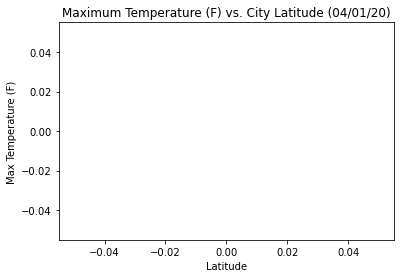

In [84]:
lat_vs_T_axes = remaining_cities.plot(kind="scatter", x="Latitude", y="Max Temperature (F)", 
                                      title="Maximum Temperature (F) vs. City Latitude (04/01/20)")

lat_vs_T_axes.get_figure().savefig("../output_data/Temp_vs_Latitude_All_Cities.png")

## Latitude vs. Humidity Plot

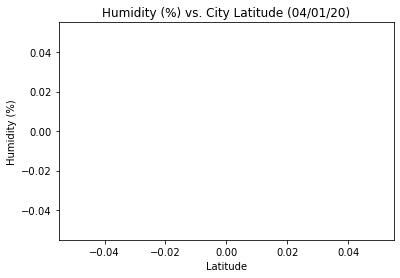

In [85]:
lat_vs_humidity_axes = remaining_cities.plot(kind="scatter", x="Latitude", y="Humidity (%)", 
                                      title="Humidity (%) vs. City Latitude (04/01/20)")

lat_vs_humidity_axes.get_figure().savefig("../output_data/Humidity_vs_Latitude_All_Cities.png")

## Latitude vs. Cloudiness Plot

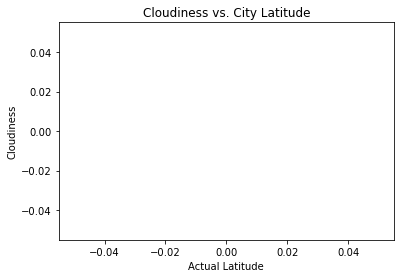

In [86]:
lat_vs_cloudiness_axes = remaining_cities.plot(kind="scatter", x="Actual Latitude", y="Cloudiness", 
                                      title="Cloudiness vs. City Latitude")

lat_vs_cloudiness_axes.get_figure().savefig("../output_data/Cloudiness_vs_Latitude_All_Cities.png")

## Latitude vs. Wind Speed Plot

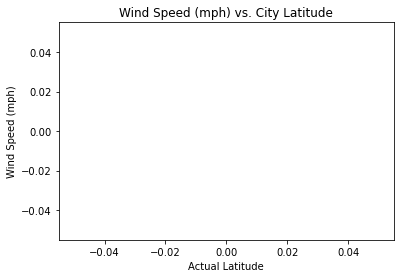

In [87]:
lat_vs_wind_speed_axes = remaining_cities.plot(kind="scatter", x="Actual Latitude", y="Wind Speed (mph)", 
                                      title="Wind Speed (mph) vs. City Latitude")

lat_vs_wind_speed_axes.get_figure().savefig("../output_data/Wind_Speed_vs_Latitude_All_Cities.png")

## Linear Regression

In [88]:
# OPTIONAL: Create a function to create Linear Regression plots

#takes in as arguments a DataFrame (df), the x-axis String column name (x_Col), and the y-axis String column name (y_Col)
#plots a scatter plot with the df[x_Col] on the x-axis and the df[y_Col] data on the y-axis, and the linear regression line
#prints information about the best fit line from the linear regression
#returns the axes object for the plot, so more changes can be made later if necessary
def makeLinRegression(df, x_Col, y_Col):
    #first, perform the linear regression on the data
    (regr_slope, regr_intercept, regr_r_val, _, _) = linregress(df[x_Col], 
                                                           df[y_Col])
    #setup the linear regression line x and y axes data points
    regr_line_x = np.array([a for a in range(int(min(df[x_Col].values)), int(max(df[x_Col].values)+1))])
    regr_line_y = regr_slope * regr_line_x + regr_intercept

    #plot the scatterplot with the raw data first!
    df_axes = df.plot(kind="scatter", x=x_Col, y=y_Col, 
                      title="{} vs. {} ({})"
                        .format(y_Col, x_Col, remaining_cities["Datetime (Local)"].iloc[0].split(",")[0]))

    #add the best fit lines to the plot as a solid red line
    df_axes.plot(regr_line_x, regr_line_y, 'r')

    #output best-fit line information
    print("The equation of the best-fit linear regression line for this chart is y={:.2f}x+{:.2f}"
          .format(regr_slope, regr_intercept))
    print("The r-squared correlation coefficient for this line is {:.2f}".format(regr_r_val))
                  
    #return the axes object for the plots, in case any changes need to be made
    return df_axes

In [90]:
# Create Northern and Southern Hemisphere DataFrames

#first, get a subset of all the cities that are on or north of the equator for the Northern Hemisphere DataFrame
northern_hemisphere = remaining_cities.loc[remaining_cities["Latitude"] >= 0]
northern_cities_count = len(northern_hemisphere)
print("There are {} cities in the northern hemisphere out of {} cities total, representing {:.1%} of all cities in the data set."
     .format(northern_cities_count, city_left_count, (northern_cities_count/city_left_count)))

#first, get a subset of all the cities that are south of the equator for the Southern Hemisphere DataFrame
southern_hemisphere = remaining_cities.loc[remaining_cities["Latitude"] < 0]
southern_cities_count = len(southern_hemisphere)
print("There are {} cities in the southern hemisphere out of {} cities total, representing {:.1%} of all cities in the data set."
     .format(southern_cities_count, city_left_count, (southern_cities_count/city_left_count)))

There are 405 cities in the northern hemisphere out of 615 cities total, representing 65.9% of all cities in the data set.
There are 210 cities in the southern hemisphere out of 615 cities total, representing 34.1% of all cities in the data set.


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=nanx+nan
The r-squared correlation coefficient for this line is nan


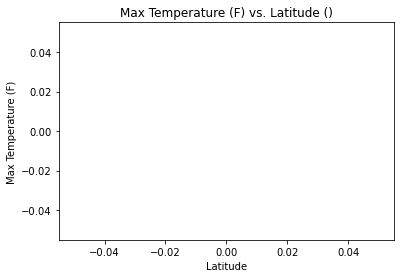

In [118]:
(n_temp_slope, n_temp_intercept, n_temp_r_val, _, _) = linregress(northern_hemisphere["Latitude"], 
                                                           northern_hemisphere["Max Temperature (F)"])

regr_line_x = np.array([a for a in range(80)])
regr_line_y = n_temp_slope * regr_line_x + n_temp_intercept

n_temp_axes = northern_hemisphere.plot(kind="scatter", x="Latitude", 
                                       y="Max Temperature (F)", 
                                       title="Max Temperature (F) vs. Latitude ({})".
                                       format(remaining_cities["Datetime (Local)"].iloc[0].split(",")[0]))
                        

n_temp_axes.plot(regr_line_x, regr_line_y, 'r')

print("The equation of the best-fit linear regression line for this chart is y={:.2f}x+{:.2f}"
      .format(n_temp_slope, n_temp_intercept))
print("The r-squared correlation coefficient for this line is {:.2f}".format(n_temp_r_val))
n_temp_axes.get_figure().savefig("../output_data/Temp_vs_Latitude_N_Hemisphere.png")


The equation of the best-fit linear regression line for this chart is y=nanx+nan
The r-squared correlation coefficient for this line is nan


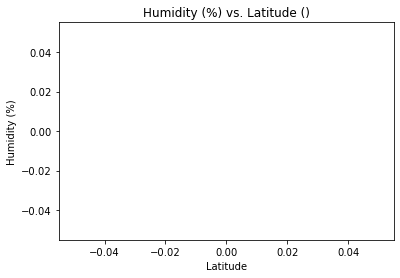

In [93]:
n_humidity_lat_axes = makeLinRegression(northern_hemisphere, "Latitude", "Humidity (%)")
n_humidity_lat_axes.get_figure().savefig("../output_data/Humidity_vs_Latitude_N_Hemisphere.png")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=nanx+nan
The r-squared correlation coefficient for this line is nan


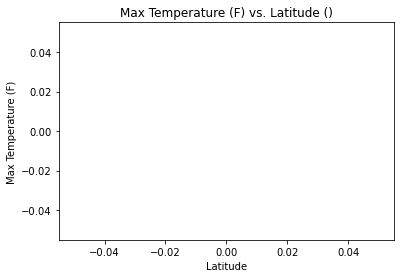

In [95]:
s_temp_lat_axes = makeLinRegression(southern_hemisphere, "Latitude", "Max Temperature (F)")
s_temp_lat_axes.get_figure().savefig("../output_data/Temp_vs_Latitude_S_Hemisphere.png")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=nanx+nan
The r-squared correlation coefficient for this line is nan


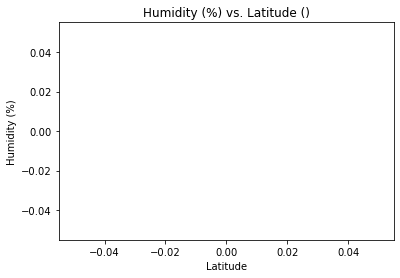

In [97]:
n_humidity_lat_axes = makeLinRegression(northern_hemisphere, "Latitude", "Humidity (%)")
n_humidity_lat_axes.get_figure().savefig("../output_data/Humidity_vs_Latitude_N_Hemisphere.png")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=nanx+nan
The r-squared correlation coefficient for this line is nan


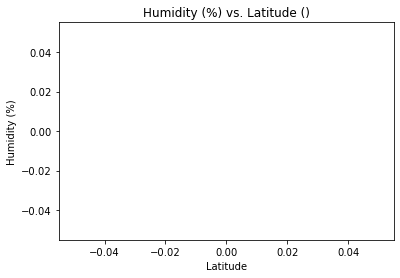

In [99]:
s_humidity_lat_axes = makeLinRegression(southern_hemisphere, "Latitude", "Humidity (%)")
s_humidity_lat_axes.get_figure().savefig("../output_data/Humidity_vs_Latitude_S_Hemisphere.png")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=nanx+nan
The r-squared correlation coefficient for this line is nan


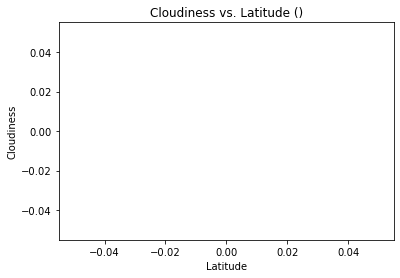

In [101]:
n_cloudiness_lat_axes = makeLinRegression(northern_hemisphere, "Latitude", "Cloudiness")
n_cloudiness_lat_axes.get_figure().savefig("../output_data/Cloudiness_vs_Latitude_N_Hemisphere.png")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=nanx+nan
The r-squared correlation coefficient for this line is nan


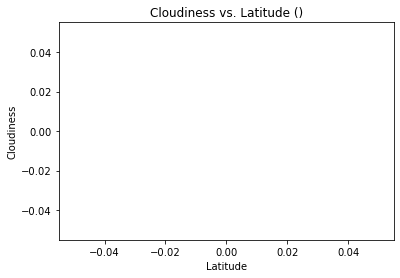

In [102]:
s_cloudiness_lat_axes = makeLinRegression(southern_hemisphere, "Latitude", "Cloudiness")
s_cloudiness_lat_axes.get_figure().savefig("../output_data/Cloudiness_vs_Latitude_S_Hemisphere.png")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=nanx+nan
The r-squared correlation coefficient for this line is nan


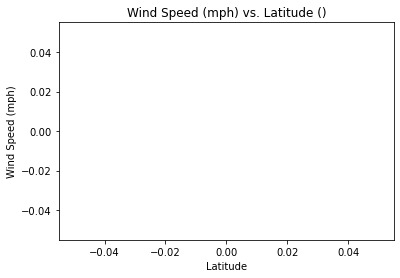

In [104]:
n_wind_lat_axes = makeLinRegression(northern_hemisphere, "Latitude", "Wind Speed (mph)")
n_wind_lat_axes.get_figure().savefig("../output_data/Wind_Speed_vs_Latitude_N_Hemisphere.png")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=nanx+nan
The r-squared correlation coefficient for this line is nan


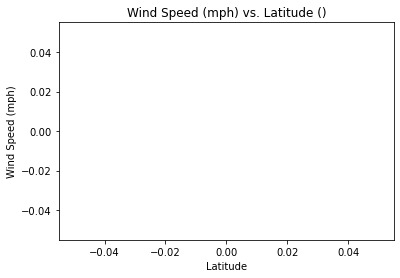

In [106]:
s_wind_lat_axes=makeLinRegression(southern_hemisphere, "Latitude", "Wind Speed (mph)")
s_wind_lat_axes.get_figure().savefig("../output_data/Wind_Speed_vs_Latitude_S_Hemisphere.png")